<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-scripts-and-datasets" data-toc-modified-id="Import-scripts-and-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import scripts and datasets</a></span></li><li><span><a href="#Rank-sum-test" data-toc-modified-id="Rank-sum-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Rank-sum test</a></span></li><li><span><a href="#Gradient-boosting-tree-as-single-cell-classifiers" data-toc-modified-id="Gradient-boosting-tree-as-single-cell-classifiers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient boosting tree as single cell classifiers</a></span></li><li><span><a href="#Model-explaination-using-SHAP-values" data-toc-modified-id="Model-explaination-using-SHAP-values-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model explaination using SHAP values</a></span></li><li><span><a href="#Feature-selection-using-mean-SHAP" data-toc-modified-id="Feature-selection-using-mean-SHAP-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature selection using mean SHAP</a></span></li><li><span><a href="#Apply-workflow-on-the-ICC-dataset" data-toc-modified-id="Apply-workflow-on-the-ICC-dataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Apply workflow on the ICC dataset</a></span></li></ul></div>

## Import scripts and datasets

In [7]:
import sys
sys.path.append('../scripts')

import utils,analysis,test_features
import SCCML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

HIP_CER_df = pd.read_pickle('../data/HIP_CER.pkl')
ICC_df = pd.read_pickle('../data/ICC_rms.pkl')
SIMS_df = pd.read_pickle('../data/SIMS.pkl')

In [8]:
HIP_CER_df.head(5)

,54.1983,56.1029,56.5342,56.6536,56.7016,58.7696,59.0109,59.2733,59.4318,59.5242,...,499.1488,499.1646,499.1701,499.1804,499.1942,499.2141,499.2251,499.2478,499.2911,type
x_10020y_24575.d,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.007411,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,Hippocampal
x_10192y_5819.d,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.021001,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,Cerebellar
x_10348y_24164.d,0.007193,0.0,0.024173,0.0,0.005693,0.0,0.0,0.0,0.0,0.0,...,0.0,0.034015,0.0,0.013435,0.0,0.0,0.0,0.0,0.003867,Cerebellar
x_10673y_24096.d,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.007250,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,Hippocampal
x_10683y_25227.d,0.007479,0.0,0.028056,0.0,0.004818,0.0,0.0,0.0,0.0,0.0,...,0.0,0.034504,0.0,0.013386,0.0,0.0,0.0,0.0,0.005504,Cerebellar


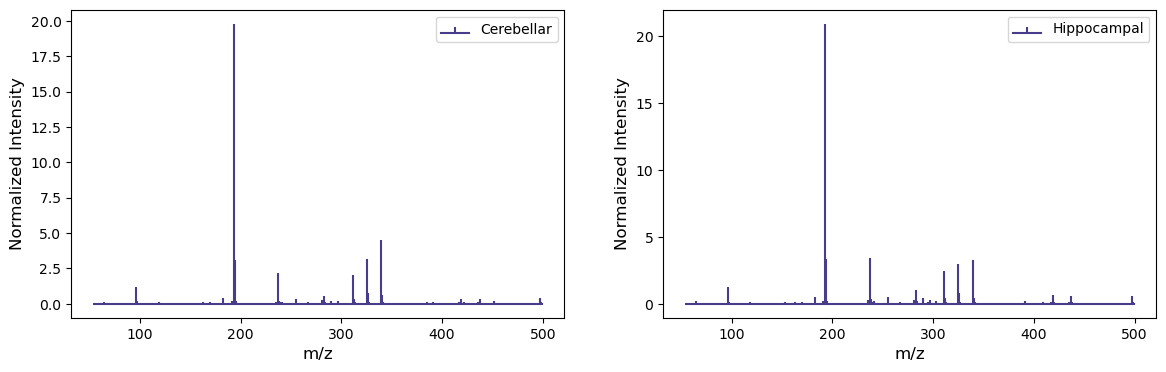

In [10]:
def plot_avg_spec(data):
    types = list(set(data['type']))
    fig,axes=subplots(1,len(types),figsize=(7*len(types),4))
    ax = axes.ravel()
    
    mzs = np.array(data.columns[data.columns!='type'])
        
    for i in range(len(types)):
        
        ax[i].stem(mzs,data[data['type']==types[i]].mean(numeric_only=True),label=types[i],basefmt='darkslateblue',markerfmt=' ',linefmt='darkslateblue')
        ax[i].set_ylabel('Normalized Intensity',fontsize=12)
        ax[i].set_xlabel('m/z',fontsize=12)
        ax[i].legend()
    
plot_avg_spec(data=HIP_CER_df)
#plot_avg_spec(data=ICC_df,mzs=ICC_df.columns)
#plot_avg_spec(data=SIMS_df,mzs=SIMS_df.columns)

## Rank-sum test

In [2]:
def rank_sum(data,groups):
    
    x = data.loc[data['type']==groups[0], data.columns != 'type'].values
    y = data.loc[data['type']==groups[1], data.columns != 'type'].values
    
    mzs = np.array(data.columns[data.columns!='type'])
        
    O,F,P=analysis.rank_sum_test(x,y,mzs,10000)
#     plt.figure(figsize=(5,3))
#     plt.hist(np.log10(P),30)
#     plt.xlabel('log 10 p-value')
#     plt.ylabel('number of mz features')
    return O,F,P

O,F,P1 = rank_sum(HIP_CER_df,['Hippocampal','Cerebellar'])
O,F,P2 = rank_sum(ICC_df,['Astrocytes','Neurons'])
O,F,P3 = rank_sum(SIMS_df,['DRG','CER'])

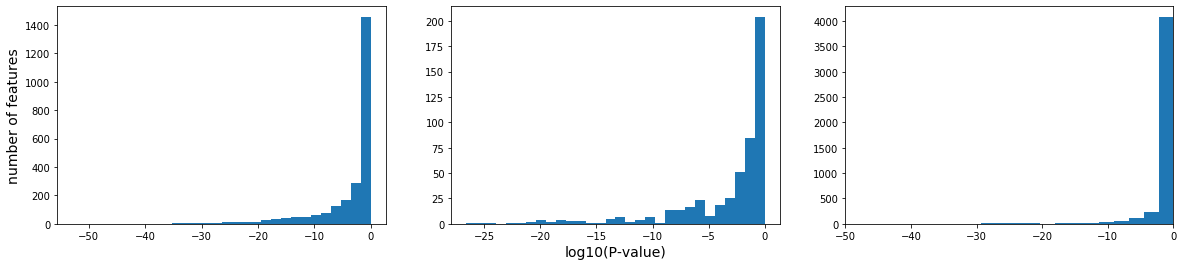

In [48]:
fig,axes = subplots(1,3,figsize=(20,4))
ax = axes.ravel()
ax[0].hist(np.log10(P1),30)
ax[0].set_ylabel('number of features',fontsize=14)
ax[1].hist(np.log10(P2),30)
ax[1].set_xlabel('log10(P-value)',fontsize=14)
ax[2].hist(np.log10(P3),100)
ax[2].set_xlim([-50,0])
fig.savefig('pvalues.tif')

## Gradient boosting tree as single cell classifiers

In [6]:
#split the dataset into training and test set
from sklearn.model_selection import train_test_split

def split_data(data,test_size,random_state):

    X_train, X_test, y_train, y_test = train_test_split(data.drop('type',1).values, data['type'].values, 
                                                        test_size=test_size,
                                                        random_state=random_state)

    data_dict = {'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test}

    return data_dict

data_dict_hip_cer = split_data(data=HIP_CER_df,test_size=0.2,random_state=19)
data_dict_icc = split_data(data=ICC_df,test_size=0.2,random_state=19)
#data_dict_sims = split_data(data=SIMS_df,test_size=0.2,random_state=19)

In [36]:
import xgboost
from sklearn.metrics import classification_report 

model = xgboost.XGBClassifier(n_estimators=500,subsample=1)

def train_model(model,data_dict):
    
    model.fit(data_dict['X_train'],data_dict['y_train'])

    y_pred = model.predict(data_dict['X_test'])
    prob = model.predict_proba(data_dict['X_test'])
    report_dict = classification_report(data_dict['y_test'], y_pred, output_dict=True)
    
    return model, y_pred, prob

model, y_pred, prob = train_model(model,data_dict_hip_cer)

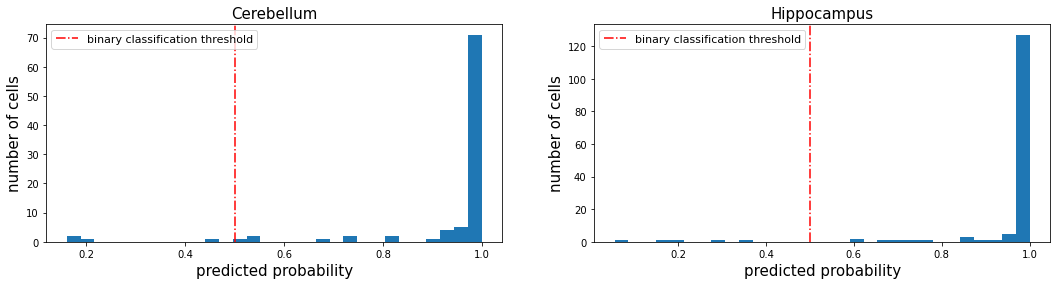

In [13]:
fig,axes = subplots(1,2,figsize=(18,4))
ax = axes.ravel()

ax[0].hist(prob[np.where(data_dict_hip_cer['y_test']=='Cerebellar')[0],0],bins=30)
ax[0].set_title('Cerebellum',fontsize=15)
ax[1].hist(prob[np.where(data_dict_hip_cer['y_test']=='Hippocampal')[0],1],bins=30)
ax[1].set_title('Hippocampus',fontsize=15)
ax[0].set_ylabel('number of cells',fontsize=15)
ax[1].set_ylabel('number of cells',fontsize=15)
ax[0].set_xlabel('predicted probability',fontsize=15)
ax[1].set_xlabel('predicted probability',fontsize=15)
ax[0].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[1].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[0].legend(fontsize=11,loc=2)
ax[1].legend(fontsize=11)

../scripts\SCCML.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(features,feature_imp,markerfmt=' ')


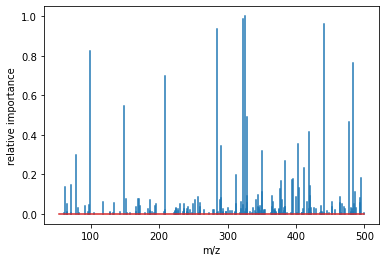

In [38]:
features = HIP_CER_df.columns[:-1]
_,f_selected = SCCML.plot_featureImp_glob(model,features,0)

## Model explaination using SHAP values

../scripts\SCCML.py:57: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  g=axes.stem([float(x) for x in features],shap_vals.mean(axis=0),markerfmt=' ',linefmt='k')
No handles with labels found to put in legend.


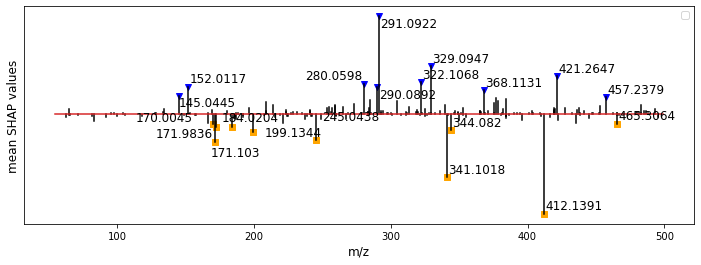

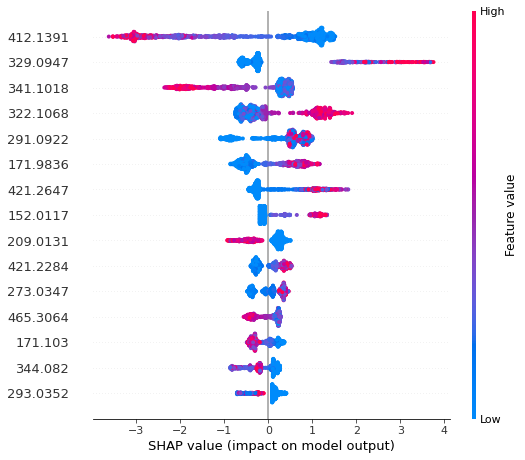

In [39]:
_,_,contrib_xgb_best = SCCML.feature_contrib(model,HIP_CER_df.drop('type',1),
                                             HIP_CER_df.columns[:-1],10,True)

In [42]:
shap_ranked_index = np.argsort(abs(contrib_xgb_best).mean(0))[::-1]

X_df = pd.DataFrame(HIP_CER_df.drop('type',axis=1))
X_df.columns = HIP_CER_df.columns[:-1]

contrib_df = pd.DataFrame()
contrib_df['mass'] = features[shap_ranked_index]
contrib_df['mean SHAP'] = np.around(abs(contrib_xgb_best).mean(0),4)[shap_ranked_index]
contrib_df['mean SHAP'] = np.round(contrib_df['mean SHAP']/contrib_df['mean SHAP'].max(),4)
a=X_df.values*contrib_xgb_best
contrib_df.loc[a.mean(0)[shap_ranked_index]>0,'contribute to which GOI']='Hippocampal'
contrib_df.loc[a.mean(0)[shap_ranked_index]<0,'contribute to which GOI']='Cerebellar'
contrib_df = contrib_df[contrib_df['mean SHAP']!=0]
contrib_df.head(10)

,mass,mean SHAP,contribute to which GOI
0,412.139,1.0000,Cerebellar
1,329.095,0.5092,Hippocampal
2,341.102,0.4804,Cerebellar
3,322.107,0.4333,Hippocampal
4,291.092,0.4290,Hippocampal
5,171.984,0.3620,Hippocampal
6,421.265,0.3486,Hippocampal
7,152.012,0.2112,Hippocampal
8,209.013,0.1990,Cerebellar
9,421.228,0.1815,Hippocampal


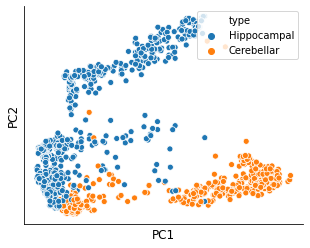

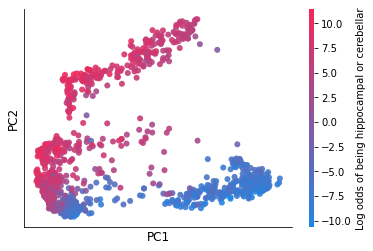

In [18]:
_,_,shap_pca = SCCML.shap_clustering(contrib_xgb_best,HIP_CER_df['type'].values)

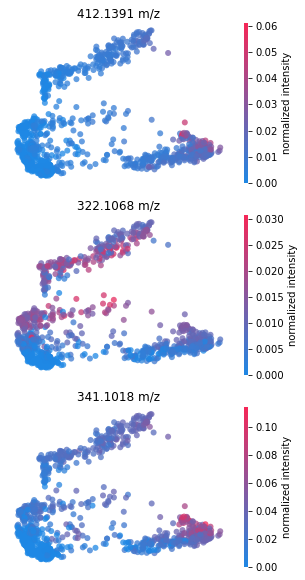

In [19]:
selected_mass = [412.1391,322.1068,341.1018]
_ = SCCML.plot_shap_features(contrib_xgb_best,HIP_CER_df.drop('type',1),selected_mass)

## Feature selection using mean SHAP

In [20]:
label_ = HIP_CER_df['type'].values.copy()
label_[label_=='Hippocampal'] = 1
label_[label_=='Cerebellar'] = 0

acc,recall,f1,auc = test_features.feature_select(HIP_CER_df.drop('type',1),label_,
                                                 model,shap_ranked_index,100)

auc: 0.772994768962511
auc: 0.845066841034583
auc: 0.881974716652136
auc: 0.9440206335367627
auc: 0.9560447544318512
auc: 0.9677782621331008
auc: 0.9728276663760534
auc: 0.9760244115082825
auc: 0.9811827956989247
auc: 0.9801656495204882
auc: 0.9779860505666957
auc: 0.9819819819819819
auc: 0.981400755594304
auc: 0.9813281022958443
auc: 0.9867770996803255
auc: 0.985759953501889
auc: 0.9856146469049695
auc: 0.9869950595757047
auc: 0.9867770996803255
auc: 0.9873583260680034
auc: 0.9875762859633825
auc: 0.9902644580063935
auc: 0.9881575123510608
auc: 0.9875036326649229
auc: 0.9872856727695437
auc: 0.9888840453356582
auc: 0.9876489392618426
auc: 0.9910636442894508
auc: 0.9891746585294972
auc: 0.9905550712002326
auc: 0.9906277244986922
auc: 0.9901918047079338
auc: 0.9906277244986922
auc: 0.9899011915140947
auc: 0.9891746585294972
auc: 0.9896105783202558
auc: 0.9903371113048532
auc: 0.9910636442894507
auc: 0.989537925021796
auc: 0.9900464981110142
auc: 0.990700377797152
auc: 0.9910636442894507

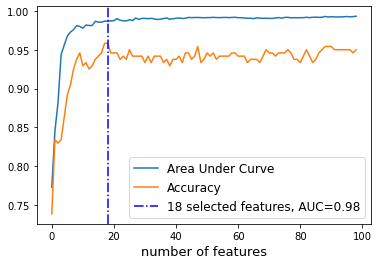

In [22]:
fig,axes = subplots(1,1)
axes.plot(auc,label='Area Under Curve')
axes.plot(acc,label='Accuracy')
axes.axvline(18,linestyle='-.',c='b',label='18 selected features, AUC=0.98')
axes.set_xlabel('number of features',fontsize=13)
plt.legend(fontsize=12)

In [23]:
acc1,recall1,f11,auc_1 = test_features.feature_sampling(HIP_CER_df.drop('type',1),label_,model,18,300)

auc: 0.7388477186864284
auc: 0.794500145306597
auc: 0.8380557977332173
auc: 0.9007919209532114
auc: 0.7808049985469341
auc: 0.899447834931706
auc: 0.850297878523685
auc: 0.8428145887823306
auc: 0.8004213891310665
auc: 0.9104911362975879
auc: 0.8110287707061901
auc: 0.8202920662598082
auc: 0.9081299040976459
auc: 0.8861886079628015
auc: 0.708115373437954
auc: 0.8392909038070329
auc: 0.8880412670735252
auc: 0.7622784074396978
auc: 0.91572217378669
auc: 0.8361668119732636
auc: 0.8121548968323161
auc: 0.8182941005521651
auc: 0.8385280441732055
auc: 0.8213455390874745
auc: 0.8415431560592851
auc: 0.7829119442022667
auc: 0.9252034292356872
auc: 0.8886588201104331
auc: 0.7729221156640512
auc: 0.7993315896541704
auc: 0.8233071781458878
auc: 0.814843068875327
auc: 0.8789596047660564
auc: 0.8691514094739902
auc: 0.8686791630340018
auc: 0.8538578901482127
auc: 0.9297442603894218
auc: 0.8906204591688462
auc: 0.9311246730601569
auc: 0.8586530078465563
auc: 0.9052964254577157
auc: 0.9014094739901191

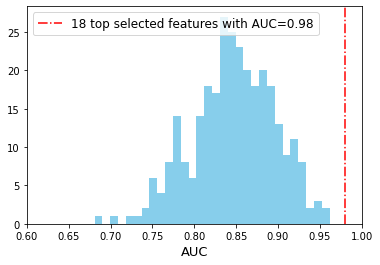

In [25]:
fig,axes = subplots(1,1)
axes.hist(auc_1,bins=30, color = "skyblue")
axes.axvline(0.98,linestyle='-.',c='r',label='18 top selected features with AUC=0.98')
axes.set_xlim([0.6,1])
axes.set_xlabel('AUC',fontsize=13)
plt.legend(fontsize=12)

## Apply workflow on the ICC dataset

In [43]:
from sklearn.externals import joblib
model = joblib.load('xgb_best.sav')
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

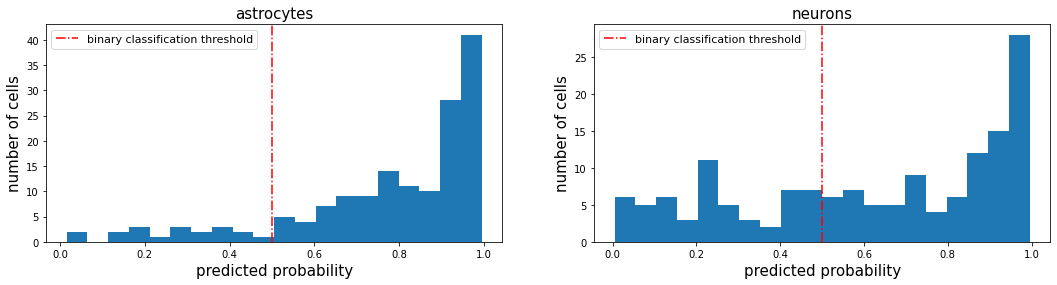

In [44]:
model, y_pred, prob = train_model(model,data_dict_icc)

fig,axes = subplots(1,2,figsize=(18,4))
ax = axes.ravel()
ax[0].hist(prob[data_dict_icc['y_test']=='Astrocytes'][:,0],bins=20)
ax[0].set_title('astrocytes',fontsize=15)
ax[1].hist(prob[data_dict_icc['y_test']=='Neurons'][:,1],bins=20)
ax[1].set_title('neurons',fontsize=15)
ax[0].set_ylabel('number of cells',fontsize=15)
ax[1].set_ylabel('number of cells',fontsize=15)
ax[0].set_xlabel('predicted probability',fontsize=15)
ax[1].set_xlabel('predicted probability',fontsize=15)
ax[0].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[1].axvline(0.5,linestyle='-.',c='r',label='binary classification threshold')
ax[0].legend(fontsize=11,)
ax[1].legend(fontsize=11)

../scripts\SCCML.py:57: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  g=axes.stem([float(x) for x in features],shap_vals.mean(axis=0),markerfmt=' ',linefmt='k')
No handles with labels found to put in legend.


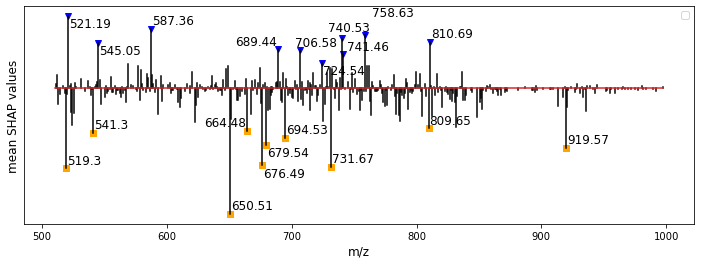

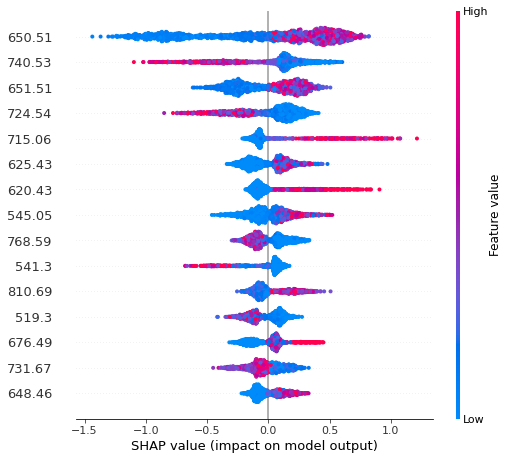

In [45]:
features = ICC_df.columns[:-1]
_,_,contrib_xgb_best = SCCML.feature_contrib(model,ICC_df.drop('type',1),
                                             ICC_df.columns[:-1],10,True)

In [47]:
shap_ranked_index = np.argsort(abs(contrib_xgb_best).mean(0))[::-1]

X_df = pd.DataFrame(ICC_df.drop('type',axis=1))
X_df.columns = ICC_df.columns[:-1]

contrib_df = pd.DataFrame()
contrib_df['mass'] = features[shap_ranked_index]
contrib_df['mean SHAP'] = np.around(abs(contrib_xgb_best).mean(0),4)[shap_ranked_index]
contrib_df['mean SHAP'] = np.round(contrib_df['mean SHAP']/contrib_df['mean SHAP'].max(),4)
a=X_df.values*contrib_xgb_best
contrib_df.loc[a.mean(0)[shap_ranked_index]>0,'contribute to which GOI']='Neuron'
contrib_df.loc[a.mean(0)[shap_ranked_index]<0,'contribute to which GOI']='Astrocyte'
contrib_df = contrib_df[contrib_df['mean SHAP']!=0]
contrib_df.head(10)

,mass,mean SHAP,contribute to which GOI
0,650.51,1.0000,Neuron
1,740.53,0.5486,Astrocyte
2,651.51,0.4883,Neuron
3,724.54,0.4404,Astrocyte
4,715.06,0.3079,Neuron
5,625.43,0.3005,Neuron
6,620.43,0.2915,Neuron
7,545.05,0.2753,Neuron
8,768.59,0.2578,Astrocyte
9,541.3,0.2476,Astrocyte


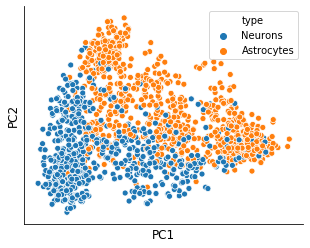

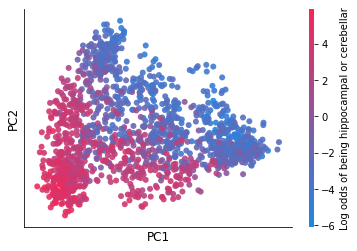

In [10]:
_,_,shap_pca = SCCML.shap_clustering(contrib_xgb_best,ICC_df['type'].values)

In [48]:
label_ = ICC_df['type'].values.copy()
label_[label_=='Neurons'] = 1
label_[label_=='Astrocytes'] = 0

acc,recall,f1,auc = test_features.feature_select(ICC_df.drop('type',1),label_,
                                                 model,shap_ranked_index,100)

auc: 0.6033355682199129
auc: 0.6222343278578613
auc: 0.6163887026483406
auc: 0.678029668119343
auc: 0.6885056989607778
auc: 0.7030254777070064
auc: 0.721714716728126
auc: 0.7193890378813276
auc: 0.736339255782769
auc: 0.7637445524639624
auc: 0.7575846463291989
auc: 0.775058665772712
auc: 0.7699463627220919
auc: 0.7694854173650687
auc: 0.7628645658732818
auc: 0.7704911163258464
auc: 0.7663426081126383
auc: 0.7752262822661751
auc: 0.771999664767013
auc: 0.7874203821656052
auc: 0.7797938317130406
auc: 0.7873784780422394
auc: 0.7689825678846798
auc: 0.7735501173315454
auc: 0.781009051290647
auc: 0.7849480388870265
auc: 0.7806738183037212
auc: 0.7922812604760309
auc: 0.76927589674824
auc: 0.7926164934629567
auc: 0.8112638283607106
auc: 0.7994468655715723
auc: 0.8150351994636272
auc: 0.8131495139121689
auc: 0.8076600737512571
auc: 0.8131495139121689
auc: 0.8115990613476366
auc: 0.8183456252095206
auc: 0.8203151190077103
auc: 0.8211951055983909
auc: 0.818932282936641
auc: 0.8292826014079785
a

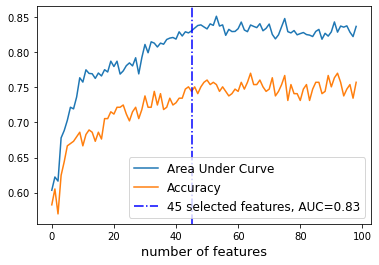

In [49]:
fig,axes = subplots(1,1)
axes.plot(auc,label='Area Under Curve')
axes.plot(acc,label='Accuracy')
axes.axvline(45,linestyle='-.',c='b',label='45 selected features, AUC=0.83')
axes.set_xlabel('number of features',fontsize=13)
plt.legend(fontsize=12)

In [50]:
acc1,recall1,f11,auc_1 = test_features.feature_sampling(ICC_df.drop('type',1),label_,model,45,300)

auc: 0.7525142474019444
auc: 0.7854089842440496
auc: 0.720415688903788
auc: 0.7609369761984578
auc: 0.7517180690579953
auc: 0.7738853503184714
auc: 0.7868756285618504
auc: 0.7881746563861884
auc: 0.7620683875293329
auc: 0.7916946027489106
auc: 0.7451810258129401
auc: 0.770072075092189
auc: 0.7379316124706671
auc: 0.7805900100569897
auc: 0.7225108950720751
auc: 0.7650435802883003
auc: 0.7392306402950051
auc: 0.7956335903452899
auc: 0.7832718739523968
auc: 0.7668035534696613
auc: 0.7651692926583975
auc: 0.751005698960778
auc: 0.7359202145491116
auc: 0.7711196781763324
auc: 0.7569979886020785
auc: 0.7721672812604761
auc: 0.7606855514582636
auc: 0.7431696278913846
auc: 0.7982316459939658
auc: 0.7805900100569896
auc: 0.7559084813945692
auc: 0.7607274555816291
auc: 0.7642474019443514
auc: 0.8272712034864231
auc: 0.7453067381830372
auc: 0.7371773382500837
auc: 0.774723432785786
auc: 0.8019192088501508
auc: 0.8175913509889372
auc: 0.7267851156553805
auc: 0.7793328863560174
auc: 0.8105933623868

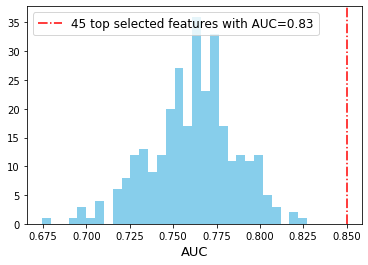

In [51]:
fig,axes = subplots(1,1)
axes.hist(auc_1,bins=30, color = "skyblue")
axes.axvline(0.85,linestyle='-.',c='r',label='45 top selected features with AUC=0.83')
axes.set_xlabel('AUC',fontsize=13)
plt.legend(fontsize=12)